<a href="https://colab.research.google.com/github/Ash100/CADD_Project/blob/main/Maximum_Common_Substructure_Part_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search for a Maximum common substructure

My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TeachOpenCADD project of Volkamer Lab. Students and Researchers with a basic Biology background found difficult to run these analysis directly. Therefore, with some minor modification, this notebook allows everyone to directly use it for analysis. Also this notebook is primarily cloned for teaching and research purposes. For a detail video tutorial, Bioinformatics Insights https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

Authors:

- Oliver Nagel, CADD Seminars, 2017, Charité/FU Berlin
- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab](https://volkamerlab.org), Charité
- Andrea Volkamer, 2019-2020, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

Clustering and classification of large scale chemical data is essential for navigation, analysis and knowledge discovery in a wide variety of chemical application domains in drug discovery.

In the last talktorial, we learned how to group molecules (clustering) and found that the molecules in one cluster look similar to each other and share a common scaffold. Besides visual inspection, we will learn here how to calculate the maximum substructure that a set of molecules has in common.

### Contents in *Theory*

* Introduction to identification of maximum common substructure in a set of molecules
* Detailed explanation of the FMCS algorithm

### Contents in *Practical*

* Load and draw molecules
* Run the FMCS algorithm with different input parameters
* A more diverse set: the EGFR compounds downloaded from ChEMBL
* Identification of MCS using interactive cut-off adaption

### References

* Dalke A, Hastings J., FMCS: a novel algorithm for the multiple MCS problem. [*J. Cheminf.* 2013; **5** (Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/)
* Raymond JW., Willet P., Maximum common subgraph isomorphism algorithms for the matching of chemical structures. [*J Comput Aided Mol Des.* 2002 Jul; **16**(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909)
* [Dalke's website with info on algorithm](http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html)
* [RDKit Cookbook documentation on MCS](http://www.rdkit.org/docs/Cookbook.html#using-custom-mcs-atom-types)

## Theory

### Introduction to identification of maximum common substructure in a set of molecules

![Maximum common substructure, highlighted](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T006_compound_maximum_common_substructures/images/mymols.png?raw=1)

The maximum common structure (MCS) is defined as the largest substructure that appears in two or more candidate molecules.

* Finding the MCS = maximum common subgraph isomorphism problem
* Has many applications in the field of cheminformatics: similarity search, hierarchical clustering, or molecule alignment
* Advantages:
  * Intuitive $\rightarrow$ shared structure among candidates likely to be important
  * Provides insight into possible activity patterns
  * Easy visualization by simply highlighting the substructure

Details on MCS algorithms (see review: [*J Comput Aided Mol Des.* 2002 Jul; **16**(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909))

* Determining an MCS between two or more graphs is an NP-complete problem
* Algorithms for exact determination as well as approximations exist
  * Exact: Maximum-clique, backtracking, dynamic programming
  * Approximate: Genetic algorithm, combinatorial optimization, fragment storage, ...
  * Problem reduction: Simplify the molecular graphs


Example of an implementation: [FMCS](http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html) algorithm

* Models MCS problem as a graph isomorphism problem
* Based on subgraph enumeration and subgraph isomorphism testing

### Detailed explanation of FMCS algorithm
As explained in [*J. Cheminf.* 2013; **5**(Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/) and the respective [RDKit FMCS documentation](https://www.rdkit.org/docs/source/rdkit.Chem.fmcs.fmcs.html).

#### The simplified algorithm description

```
best_substructure = None
pick one structure in the set as query, all other as targets
for each substructure in the query:
    convert into a SMARTS string based on the desired match properties
    if SMARTS pattern exists in all of the targets:
        then it is a common substructure
        keep track of the maximum of such substructure
```

This simple approach alone will usually take a long time, but there are certain tricks used to speed up the run time.

#### Tricks to speed up the run time

<img src="https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T006_compound_maximum_common_substructures/images/speed_tricks.jpg?raw=1" width=800 />

#### A) Bond elimination


* Remove bonds that cannot be part of the MCS
* Atom and bond type information has to be present in every input structure
* Bond type: string consisting of SMARTS of the first atom, the bond and the second atom
* Exclude all bond types not present in all input structures, delete respective edges
* Result: fragmented structures with all atom information, but fewer edges (bonds)

#### B) Use the structure with the smallest largest fragment as the query

* Heuristic approach:
    * Find largest fragment of each input structure
    * Sort input structures ascending by number of bonds in largest fragment
    * Solve ties with number of atoms or input order as alternative
* The structure with the smallest largest fragment becomes the query structure
* The ones from the other input structures are the targets

#### C) Use a breadth-first search (BFS) and a priority queue to enumerate the fragment subgraphs

__C1__
* Enumeration based on growing a so called seed
* Seed: atoms/bonds in current subgraph, exclusion set (bonds not applicable for growth)
* To prevent redundancy:
    * Initial seed is first bond in the fragment, can potentially grow to size of whole fragment
    * Second seed is second bond, is excluded from using the first bond
    * Third seed starts from the third bond, excluded from using the first and second
    * ...

__C2__
* Seed grows along connected bonds (not in exclusions set or already in seed)
* All growing possibilities are considered at every step
* E.g. if there are N possible bonds for extension, $2^{N-1}$ possible new seeds are added to queue
* Enumeration ends when there are no new bonds to add to subgraph (exclude seed from queue)
* Largest seed will be processed first

#### D) Prune seeds not present in all of the other structures

* At each growth state $\rightarrow$ check if new seed exists in all other structures
* Else: Exclude seed from queue

#### E) Prune seeds without sufficient growing potential

* Evaluation of growth potential from exclusion list and possible edges for extension
* If potential smaller than current best subgraph  $\rightarrow$  exclude seed from queue

Utilizing these approaches it is then trivial to keep track of the largest subgraph which corresponds to the maximum common substructure.

In [ ]:
#Install Conda - Kernal Restart will take place
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Install mamba
!conda install -c conda-forge mamba -y

# Use mamba to install packages
!mamba install -c conda-forge -c defaults python=3.8 -y
!mamba install -c conda-forge -c defaults pip -y
!mamba install -c conda-forge -c defaults jupyterlab=3 -y
!mamba install -c conda-forge -c defaults jsonschema=4.3.0 -y
!mamba install -c conda-forge -c defaults nglview=3 -y
!mamba install -c conda-forge -c defaults ipywidgets=7.75 -y
!mamba install -c conda-forge -c defaults jupyter_client=7.4.9 -y
!mamba install -c conda-forge -c defaults 'numpy<1.24' -y
!mamba install -c conda-forge -c defaults scikit-learn -y
!mamba install -c conda-forge -c defaults 'tensorflow<=2.6' -y
!mamba install -c conda-forge -c defaults seaborn -y
!mamba install -c conda-forge -c defaults matplotlib-venn -y
!mamba install -c conda-forge -c defaults bravado -y
!mamba install -c conda-forge -c defaults requests -y
!mamba install -c conda-forge -c defaults requests-cache -y
!mamba install -c conda-forge -c defaults redo -y
!mamba install -c conda-forge -c defaults suds-community -y
!mamba install -c conda-forge -c defaults beautifulsoup4 -y
!mamba install -c conda-forge -c defaults chembl_webresource_client -y
!mamba install -c conda-forge -c defaults pypdb -y
!mamba install -c conda-forge -c defaults 'biopython<=1.77' -y
!mamba install -c conda-forge -c defaults biopandas -y
!mamba install -c conda-forge -c defaults rdkit -y
!mamba install -c conda-forge -c defaults openbabel -y
!mamba install -c conda-forge -c defaults opencadd -y
!mamba install -c conda-forge -c defaults 'biotite>=0.34.0' -y
!mamba install -c conda-forge -c defaults smina -y
!mamba install -c conda-forge -c defaults 'mdanalysis>=1.0.0' -y
!mamba install -c conda-forge -c defaults mdtraj -y
!mamba install -c conda-forge -c defaults plip -y
!mamba install -c conda-forge -c defaults openmm -y
!mamba install -c conda-forge -c defaults 'mkl<2022' -y
!mamba install -c pytorch pytorch==1.13.0 -y
!mamba install -c conda-forge -c defaults pdbfixer -y
!mamba install -c conda-forge -c defaults tqdm -y
!mamba install -c conda-forge -c defaults lxml -y
!mamba install -c conda-forge -c defaults kissim -y
!mamba install -c conda-forge -c defaults pytest -y
!mamba install -c conda-forge -c defaults pytest-xdist -y
!mamba install -c conda-forge -c defaults pytest-cov -y
!mamba install -c conda-forge -c defaults nbval -y
!mamba install -c conda-forge -c defaults shyaml -y
!mamba install -c conda-forge -c defaults 'jinja2==3.0.3' -y
!mamba install -c conda-forge -c defaults sphinx -y
!mamba install -c conda-forge -c defaults sphinx-material -y
!mamba install -c conda-forge -c defaults nbsphinx -y
!mamba install -c conda-forge -c defaults recommonmark -y
!mamba install -c conda-forge -c defaults sphinx-autodoc-typehints -y
!mamba install -c conda-forge -c defaults sphinx-copybutton -y
!mamba install -c conda-forge -c defaults sphinx-gallery -y
!mamba install -c conda-forge -c defaults autodocsumm -y

# Install pip packages
!pip install black-nb nbsphinx-link sphinxext-opengraph deepchem

## Practical

In [9]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

### Load and draw molecules

Cluster data taken from **Part 5** or later EGFR molecules from **Part 1**

In [10]:
sdf = str("/content/sample_data/molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")
# NBVAL_CHECK_OUTPUT

Set with 157 molecules loaded.


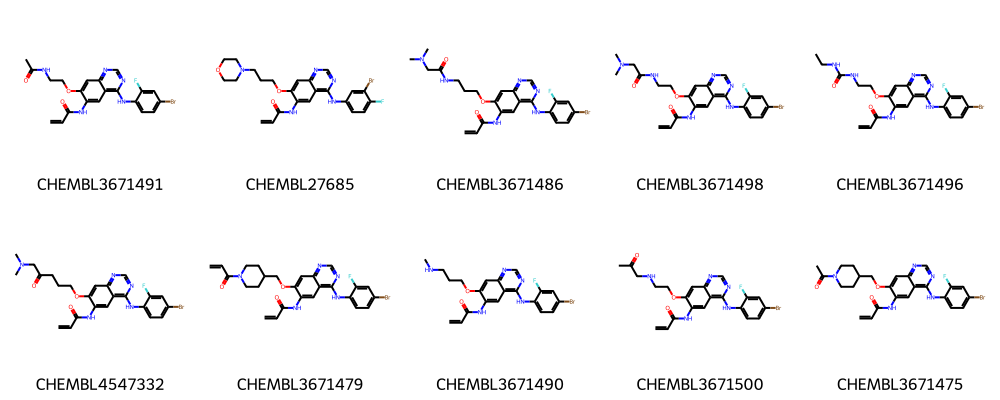

In [11]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

### Run the FMCS algorithm with different input parameters

The FMCS algorithm is implemented in RDKit: [rdFMCS](https://rdkit.org/docs/source/rdkit.Chem.rdFMCS.html)

#### Default values

In the simplest case only a list of molecules is given as a parameter.

In [12]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 24 atoms and 26 bonds.
MCS SMARTS string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


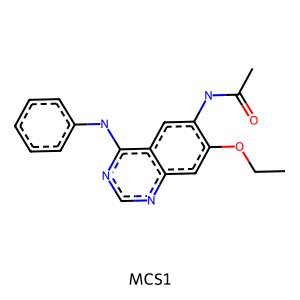

In [13]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Define a helper function to draw the molecules with the highlighted MCS.

In [14]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

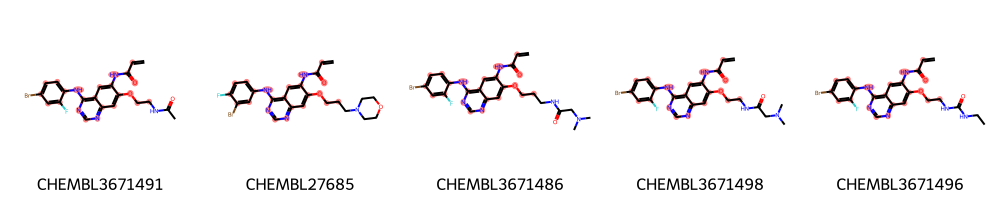

In [15]:
highlight_molecules(mols, mcs1, 5)

Save image to disk

In [17]:
img = highlight_molecules(mols, mcs1, 3, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

#### Set a threshold

It is possible to lower the threshold for the substructure, for example so that the MCS only has to occur in e.g. 80% of the input structures.

In [ ]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)
# NBVAL_CHECK_OUTPUT

In [ ]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

In [ ]:
highlight_molecules(mols, mcs2, 5)

<!-- FIXME: CI - CHEMBL27685 id is not in this subset, check that T005 produces deterministic outputs -->
As we can see in this example, some molecules were now left out due to the set threshold (`0.8`). This threshold allows to find a larger common substructure that contains, e.g., a benzene with a meta-substitution fluor pattern and a longer alkane chain.

#### Match ring bonds

In the above example it may not be obvious, but by default ring bonds can match non-ring bonds.
Often from an application point of view, we want to retain rings. Thus, one can set the `ringMatchesRingOnly` parameter to ```True```, then only ring bonds match with other ring bonds.

In [ ]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

In [ ]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

We can see here that depending on the chosen thresholds and parameters, we get slightly different MCS. Note that there are more parameter options available in the [RDKit FMCS module](https://www.rdkit.org/docs/GettingStartedInPython.html#maximum-common-substructure), e.g. considering atom, bond or valence matching.

In [ ]:
highlight_molecules(mols, mcs3, 5)

### A more diverse set: the EGFR compounds downloaded from ChEMBL

We restrict the data to only highly active molecules (pIC50>9) and detect the maximum common scaffold in this subset.

In [25]:
# Read full EGFR data
mol_df = pd.read_csv("/content/sample_data/ro5_properties1.csv", index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])
# NBVAL_CHECK_OUTPUT

Total number of compounds: 6816
Number of compounds with pIC50 > 9: 322


In [ ]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x7fa686666ca0>
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7fa686666c40>
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7fa686666be0>


We do our calculations on the selected highly active molecules only.

In [26]:
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In the interest of time, we randomly pick 50 molecules from this set.

In [27]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 50)

We now calculate the same three variants of MCSs as described above and draw the respective substructures. We use a slightly lower threshold to account for the larger diversity in the set.

In [ ]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

In [ ]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

This time it become more clear that setting `ringMatchesRingOnly=True` provides a more intuitive representation of the scaffold they share.

In [ ]:
highlight_molecules(mols_diverse_sample, mcs3, 5)

### Identification of MCS using interactive cut-off adaption

We can also change the threshold interactively. For that, we need a helper function, hereby defined. It takes two arguments: `molecules` (fixed, so it's not configurable with a widget) and `percentage` (the value of which is determined by the interactive widget). Every time you modify the state of the slider, this helper function is called.

In [31]:
def render_mcs(molecules, percentage):
    """Interactive widget helper. `molecules` must be wrapped in `ipywidgets.fixed()`,
    while `percentage` will be determined by an IntSlider widget."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(tmcs.smartsString)
    return m

In [ ]:
# Note that the slider may take a few seconds to react
interact(
    render_mcs,
    molecules=fixed(mols_diverse_sample),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=70),
);

## Discussion

Maximum substructures that a set of molecules have in common can a useful strategy to visualize common scaffolds. In this talktorial, we have use the FMCS algorithm to find the maximum common substructure within a largest cluster from **Part 5**. An interactive widget allowed us to explore the impact of different thresholds on the maximum common substructure in our dataset.